In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import random
import sys
from tqdm import tqdm

import tensorflow as tf

# <project_root>/ddnet/ddnet.py
sys.path.insert(0, os.path.join(os.path.abspath(''), '..', 'ddnet'))
import ddnet

Using TensorFlow backend.


# Initialize the setting

In [2]:
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
random.seed(123)

# directory that contains pickle files
data_dir = os.path.join(os.path.abspath(''), '..', 'data', 'openpose_zeros_all')

# Helper functions

In [4]:
def data_generator(T, C, le):
    """
    Generate X (list of arrays) and Y (array) from a dict 
    """
    X = T['pose'] # list of arrays
    Y = np.zeros(shape=(len(T['label']), C.clc_num)) # 2D array one-hot encoding of labels
    Y[range(Y.shape[0]), le.transform(T['label'])] = 1
    return X, Y

In [5]:
# helper functions for plotting
# history is a history object from keras
def plot_accuracy(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
def plot_loss(history):
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()  

## Load and Preprocess Data

In [6]:
Train = pickle.load(open(os.path.join(data_dir, "GT_train_1.pkl"), "rb"))
Test = pickle.load(open(os.path.join(data_dir, "GT_test_1.pkl"), "rb"))

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(Train['label'])

LabelEncoder()

In [7]:
C = ddnet.DDNetConfig(frame_length=32, num_joints=25, joint_dim=2, num_classes=21, num_filters=32)

X, Y = data_generator(Train,C,le)
X_test,Y_test = data_generator(Test,C,le)

print(len(X), X[0].shape, Y.shape)
print(len(X_test), X_test[0].shape, Y_test.shape)

497 (40, 25, 2) (497, 21)
195 (40, 25, 2) (195, 21)


### Convert Invisible Joints with `nan`

In [8]:
def make_nan(p, copy=True):
    """
    Convert 0 values to np.nan
    """
    assert isinstance(p, np.ndarray)
    q = p.copy() if copy else p
    q[q == 0] = np.nan
    return q

def has_nan(p):
    assert isinstance(p, np.ndarray)
    return np.isnan(p).any()

def count_nan(p):
    assert isinstance(p, np.ndarray)
    return np.isnan(p).sum()

X_nan = list(map(make_nan, X))
X_test_nan = list(map(make_nan, X_test))

print("Video without any nan: {} out of {}".format(len([p for p in X_nan if not has_nan(p)]), len(X_nan)))
print("nan entries in X_nan: {} out of {}".format(sum(map(count_nan, X_nan)), sum([p.size for p in X_nan])))

Video without any nan: 4 out of 497
nan entries in X_nan: 270780 out of 923200


### Preprocessing
* Select a subset of frequently-detected joints
* Temporal interpolate
* Fill the others with mean

In [9]:
def find_top_joints(X_nan, top=15):
    """
    Find the indices of the `top` most frequently-detected joints """
    count_nan_per_joint = np.array([sum([count_nan(p[:, j, :]) for p in X_nan]) for j in range(X_nan[0].shape[1])])
    print(count_nan_per_joint)
#     print(np.sort(count_nan_per_joint))
    good_joint_idx = np.argsort(count_nan_per_joint)[:top]
    return good_joint_idx

good_joint_idx = find_top_joints(X_nan)
print("Good joint indices:", sorted(good_joint_idx.tolist()))

# note: the most frequently visible joints are not the same for train and test
test_good_joint_idx = find_top_joints(X_test_nan)
print("Good joint indices of test set: ", sorted(test_good_joint_idx.tolist()))


HAND_PICKED_GOOD_JOINTS = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 15, 16]

good_joint_idx = HAND_PICKED_GOOD_JOINTS

def filter_joints(p, good_joint_idx):
    """
    Filter a point by only keeping joints in good_joint_idx
    """
    return p[:, good_joint_idx, :]

X_topj = [filter_joints(p, good_joint_idx) for p in X_nan]
X_test_topj = [filter_joints(p, good_joint_idx) for p in X_test_nan]

print("Video with nan before/after selecting top joints: {} / {}".format(
    sum(map(has_nan, X_nan)),
    sum(map(has_nan, X_topj))
))

print("nan entries in before/after selecting top joints: {} / {}. Total {}".format(
    sum(map(count_nan, X_nan)),
    sum(map(count_nan, X_topj)),
    sum([p.size for p in X_topj])
))

[10394   442   618  3416  7010   554  3772  8436  3498  4018 12290 17528
  4020 12806 17696 12510 14292  7452 10258 20162 21580 18834 19672 20894
 18628]
Good joint indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 17, 18]
[3420  480  552 1564 2446  596 1726 3214 1190 1322 3750 5560 1366 3772
 6122 4244 5216 3394 5422 7196 7746 6594 6538 7154 6030]
Good joint indices of test set:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 15, 17]
Video with nan before/after selecting top joints: 493 / 473
nan entries in before/after selecting top joints: 270780 / 98076. Total 553920


In [10]:
def nan_helper(y):
    """Helper function to handle real indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

def temporal_interp(p):
    """
    If a joint is detected in at least one frame in a video, 
    we interpolate the nan coordinates from other frames.
    This is done independently for each joint.
    Note: it can still leave some all-nan columns if a joint is never detected in any frame.
    """
    p = p.copy()
    for j in range(p.shape[1]): # joint
        for coord in range(p.shape[2]): # x, y (,z)
            view = p[:, j, coord]
            if np.isnan(view).all() or  not np.isnan(view).any():
                continue
            nans, idx = nan_helper(view)
            view[nans]= np.interp(idx(nans), idx(~nans), view[~nans])
    return p

X_interp = list(map(temporal_interp, X_topj))
X_test_interp = list(map(temporal_interp, X_test_topj))


print("Video with nan before/after temporal interp: {} / {}".format(
    sum(map(has_nan, X_topj)),
    sum(map(has_nan, X_interp))
))

print("nan entries in before/after temporal interp: {} / {}".format(
    sum(map(count_nan, X_topj)),
    sum(map(count_nan, X_interp))
))

Video with nan before/after temporal interp: 473 / 223
nan entries in before/after temporal interp: 98076 / 41972


In [11]:
def per_video_normalize(p, copy=True):
    """
    For x,y[, z] independently:
        Normalize into between -0.5~0.5
    """
    q = p.copy() if copy else p
    for coord in range(p.shape[2]):
        view = q[:, :, coord]
        a, b = np.nanmin(view), np.nanmax(view)
#         q[:,:, coord] = (view - np.mean(view)) / np.std(view)
        view[:] = ((view - a) / (b-a)) - 0.5

    return q

X_norm = [per_video_normalize(p) for p in X_interp]
X_test_norm = [per_video_normalize(p) for p in X_test_interp]

# print(X_norm[0][:,:,1])
# print(X_test_norm[0][:,1,1])

In [28]:
# fill in the remaining nans

# def per_frame_fill_mean(p, copy=True):
#     """
#     For each frame independently:
#         for x, y[, z] independently:
#             Fill nan entries with the mean of all other joints' coordinates
#     This is defnitely not perfect, but may help.
#     """
#     q = p.copy() if copy else p
#     for f in range(q.shape[0]):
#         for coord in range(q.shape[2]): # x,y
#             view = q[f, :, coord]
#             view[np.isnan(view)] = np.nanmean(view)
    
#     return q
    
def fill_nan_random(p, copy=True, sigma=.5):
    """
    Fill nan values with normal distribution
    """
    q = p.copy() if copy else p
    q[np.isnan(q)] = np.random.randn(np.count_nonzero(np.isnan(q))) * sigma
    return q

def fill_nan_uniform(p, copy=True, a=-0.5, b=0.5):
    """
    Fill nan values with normal distribution
    """
    q = p.copy() if copy else p
    q[np.isnan(q)] = np.random.random((np.count_nonzero(np.isnan(q)),)) * (b-a) + a
    return q

def fill_nan_bottom(p, copy=True):
    q = p.copy() if copy else p
    xview = q[:,:,0]
    xview[np.isnan(xview)] = 0.
    yview = q[:,:,1]
    yview[np.isnan(yview)] = 0.5
    return q
    

# def fill_nan_col_random(p, copy=True, sigma=.1)
#     """
#     Fill each nan column with the same value drawn from normal distribution
#     """
#     q = p.copy() if copy else p
#     for j in range(q.shape[1]):
#         for coord in range(q.shape[2]):
#             view = q[:, j, coord]
#             if np.all(np.isnan(view)):
#                 view[:] = np.random.randn(1) * sigma
#     return q

def augment_nan(X, Y, num=5):
    """
    Data augmentation.
    X is a list of arrays.
    """
    Xa = []
    Ya = []
    for p1, y1 in zip(X, Y):
        Xa.extend([fill_nan_uniform(p1) for _ in range(num)])
        Ya.extend([y1] * num)

    Ya = np.stack(Ya)
    assert len(Xa) == Ya.shape[0]
    return Xa, Ya


X_aug, Y_aug = augment_nan(X_norm, Y)
print(len(X_aug), Y_aug.shape)


# X_fillnan = [fill_nan_random(p, sigma=0.5) for p in X_norm]
X_test_fillnan = [fill_nan_random(p, sigma=0.0) for p in X_test_norm]

print(X_norm[0][0], "\n\n", X_aug[0][0], "\n\n", X_aug[1][1])
    
# assert not any (map(has_nan, X_fillnan))
# X_fillnan[0][:,:,1]

2485 (2485, 21)
[[        nan         nan]
 [ 0.35648388 -0.31977062]
 [ 0.40983151 -0.28174566]
 [ 0.3976841  -0.12309938]
 [ 0.39350666  0.0025622 ]
 [ 0.29927431 -0.34172396]
 [        nan         nan]
 [        nan         nan]
 [ 0.1599167  -0.19988977]
 [ 0.19673124 -0.19405013]
 [ 0.26252287  0.0187348 ]
 [ 0.12693885 -0.22700958]
 [ 0.09422604  0.01910504]
 [        nan         nan]
 [        nan         nan]] 

 [[-0.278425   -0.00348136]
 [ 0.35648388 -0.31977062]
 [ 0.40983151 -0.28174566]
 [ 0.3976841  -0.12309938]
 [ 0.39350666  0.0025622 ]
 [ 0.29927431 -0.34172396]
 [-0.09498228  0.10119946]
 [-0.02302251 -0.16290479]
 [ 0.1599167  -0.19988977]
 [ 0.19673124 -0.19405013]
 [ 0.26252287  0.0187348 ]
 [ 0.12693885 -0.22700958]
 [ 0.09422604  0.01910504]
 [ 0.00697112  0.18625269]
 [ 0.49414327 -0.00382072]] 

 [[-0.32108098  0.17762828]
 [ 0.35649019 -0.3198716 ]
 [ 0.4098252  -0.28691214]
 [ 0.39764624 -0.12313304]
 [ 0.39762731  0.00794746]
 [ 0.299268   -0.34179969]
 [ 0

In [29]:
X_input, Y_input = X_aug, Y_aug
X_test_input, Y_test_input = X_test_fillnan, Y_test
print(X_input[0].shape)

(40, 15, 2)


### DDNet's preprocess and config

In [40]:
# redefine config with new # of joints
C = ddnet.DDNetConfig(frame_length=32, num_joints=len(good_joint_idx), joint_dim=2, num_classes=21, num_filters=32)

X_0, X_1 = ddnet.preprocess_batch(X_input, C)
X_test_0, X_test_1 = ddnet.preprocess_batch(X_test_input, C)

# Building the model

In [41]:
DD_Net = ddnet.create_DDNet(C)
DD_Net.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
M (InputLayer)                  (None, 32, 105)      0                                            
__________________________________________________________________________________________________
P (InputLayer)                  (None, 32, 15, 2)    0                                            
__________________________________________________________________________________________________
model_11 (Model)                (None, 4, 256)       436544      M[0][0]                          
                                                                 P[0][0]                          
__________________________________________________________________________________________________
global_max_pooling1d_6 (GlobalM (None, 256)          0           model_11[1][0]            

# Train, Test and Save/Load the Model

### Train and plot loss/accuracy

In [42]:
import keras
from keras import backend as K
from keras.optimizers import *

# K.set_session(tf.Session(config=tf.ConfigProto(intra_op_parallelism_threads=32, inter_op_parallelism_threads=16)))

lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=1e-5)

history1 = DD_Net.fit([X_0,X_1],Y_input,
                    batch_size=len(Y_input),
                    epochs=800,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    validation_data=([X_test_0,X_test_1],Y_test_input)      
                    )

lr = 1e-4
DD_Net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history2 = DD_Net.fit([X_0,X_1],Y_input,
                    batch_size=len(Y_input),
                    epochs=600,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    validation_data=([X_test_0,X_test_1],Y_test_input)      
                    )


Train on 2485 samples, validate on 195 samples
Epoch 1/800
2485/2485 [==============================] - 8s 3ms/step - loss: 3.8438 - accuracy: 0.0499 - val_loss: 3.0428 - val_accuracy: 0.1026
Epoch 2/800
2485/2485 [==============================] - 0s 68us/step - loss: 3.5350 - accuracy: 0.0620 - val_loss: 3.0413 - val_accuracy: 0.0821
Epoch 3/800
2485/2485 [==============================] - 0s 79us/step - loss: 3.4099 - accuracy: 0.0785 - val_loss: 3.0399 - val_accuracy: 0.0462
Epoch 4/800
2485/2485 [==============================] - 0s 79us/step - loss: 3.2856 - accuracy: 0.1010 - val_loss: 3.0377 - val_accuracy: 0.0923
Epoch 5/800
2485/2485 [==============================] - 0s 72us/step - loss: 3.1464 - accuracy: 0.1264 - val_loss: 3.0342 - val_accuracy: 0.1231
Epoch 6/800
2485/2485 [==============================] - 0s 78us/step - loss: 3.0409 - accuracy: 0.1384 - val_loss: 3.0289 - val_accuracy: 0.1385
Epoch 7/800
2485/2485 [==============================] - 0s 67us/step - loss: 

Epoch 57/800
2485/2485 [==============================] - 0s 77us/step - loss: 1.0111 - accuracy: 0.6849 - val_loss: 2.4567 - val_accuracy: 0.2256
Epoch 58/800
2485/2485 [==============================] - 0s 78us/step - loss: 1.0199 - accuracy: 0.6845 - val_loss: 2.4498 - val_accuracy: 0.2154
Epoch 59/800
2485/2485 [==============================] - 0s 76us/step - loss: 0.9899 - accuracy: 0.6966 - val_loss: 2.4459 - val_accuracy: 0.2154
Epoch 60/800
2485/2485 [==============================] - 0s 77us/step - loss: 0.9749 - accuracy: 0.7054 - val_loss: 2.4435 - val_accuracy: 0.2205
Epoch 61/800
2485/2485 [==============================] - 0s 73us/step - loss: 0.9512 - accuracy: 0.6998 - val_loss: 2.4423 - val_accuracy: 0.2359
Epoch 62/800
2485/2485 [==============================] - 0s 74us/step - loss: 0.9228 - accuracy: 0.7139 - val_loss: 2.4455 - val_accuracy: 0.2359
Epoch 63/800
2485/2485 [==============================] - 0s 68us/step - loss: 0.9292 - accuracy: 0.7155 - val_loss: 2

Epoch 113/800
2485/2485 [==============================] - 0s 74us/step - loss: 0.3519 - accuracy: 0.9038 - val_loss: 2.3869 - val_accuracy: 0.3026
Epoch 114/800
2485/2485 [==============================] - 0s 78us/step - loss: 0.3592 - accuracy: 0.9054 - val_loss: 2.3724 - val_accuracy: 0.3128
Epoch 115/800
2485/2485 [==============================] - 0s 74us/step - loss: 0.3379 - accuracy: 0.9131 - val_loss: 2.3418 - val_accuracy: 0.3077
Epoch 116/800
2485/2485 [==============================] - 0s 78us/step - loss: 0.3378 - accuracy: 0.9123 - val_loss: 2.3105 - val_accuracy: 0.3282
Epoch 117/800
2485/2485 [==============================] - 0s 69us/step - loss: 0.3478 - accuracy: 0.9082 - val_loss: 2.2903 - val_accuracy: 0.3282
Epoch 118/800
2485/2485 [==============================] - 0s 75us/step - loss: 0.3108 - accuracy: 0.9195 - val_loss: 2.2833 - val_accuracy: 0.3333
Epoch 119/800
2485/2485 [==============================] - 0s 72us/step - loss: 0.3114 - accuracy: 0.9159 - val_

Epoch 169/800
2485/2485 [==============================] - 0s 73us/step - loss: 0.1199 - accuracy: 0.9755 - val_loss: 2.4224 - val_accuracy: 0.4000
Epoch 170/800
2485/2485 [==============================] - 0s 73us/step - loss: 0.1138 - accuracy: 0.9791 - val_loss: 2.4194 - val_accuracy: 0.4051
Epoch 171/800
2485/2485 [==============================] - 0s 72us/step - loss: 0.1113 - accuracy: 0.9819 - val_loss: 2.4230 - val_accuracy: 0.4103
Epoch 172/800
2485/2485 [==============================] - 0s 72us/step - loss: 0.1100 - accuracy: 0.9775 - val_loss: 2.4237 - val_accuracy: 0.4103
Epoch 173/800
2485/2485 [==============================] - 0s 68us/step - loss: 0.1079 - accuracy: 0.9791 - val_loss: 2.4274 - val_accuracy: 0.4051
Epoch 174/800
2485/2485 [==============================] - 0s 66us/step - loss: 0.1052 - accuracy: 0.9835 - val_loss: 2.4365 - val_accuracy: 0.4205
Epoch 175/800
2485/2485 [==============================] - 0s 63us/step - loss: 0.1021 - accuracy: 0.9827 - val_

Epoch 225/800
2485/2485 [==============================] - 0s 63us/step - loss: 0.0919 - accuracy: 0.9859 - val_loss: 2.4665 - val_accuracy: 0.4615
Epoch 226/800
2485/2485 [==============================] - 0s 68us/step - loss: 0.1015 - accuracy: 0.9791 - val_loss: 2.4666 - val_accuracy: 0.4615
Epoch 227/800
2485/2485 [==============================] - 0s 64us/step - loss: 0.0919 - accuracy: 0.9847 - val_loss: 2.4663 - val_accuracy: 0.4615
Epoch 228/800
2485/2485 [==============================] - 0s 68us/step - loss: 0.1033 - accuracy: 0.9819 - val_loss: 2.4664 - val_accuracy: 0.4615
Epoch 229/800
2485/2485 [==============================] - 0s 65us/step - loss: 0.0896 - accuracy: 0.9871 - val_loss: 2.4661 - val_accuracy: 0.4615
Epoch 230/800
2485/2485 [==============================] - 0s 65us/step - loss: 0.0948 - accuracy: 0.9827 - val_loss: 2.4658 - val_accuracy: 0.4615
Epoch 231/800
2485/2485 [==============================] - 0s 63us/step - loss: 0.0924 - accuracy: 0.9863 - val_

Epoch 281/800
2485/2485 [==============================] - 0s 77us/step - loss: 0.0966 - accuracy: 0.9851 - val_loss: 2.4611 - val_accuracy: 0.4667
Epoch 282/800
2485/2485 [==============================] - 0s 72us/step - loss: 0.0843 - accuracy: 0.9875 - val_loss: 2.4607 - val_accuracy: 0.4718
Epoch 283/800
2485/2485 [==============================] - 0s 77us/step - loss: 0.0943 - accuracy: 0.9823 - val_loss: 2.4602 - val_accuracy: 0.4718
Epoch 284/800
2485/2485 [==============================] - 0s 74us/step - loss: 0.1005 - accuracy: 0.9807 - val_loss: 2.4598 - val_accuracy: 0.4718
Epoch 285/800
2485/2485 [==============================] - 0s 74us/step - loss: 0.0922 - accuracy: 0.9819 - val_loss: 2.4594 - val_accuracy: 0.4718
Epoch 286/800
2485/2485 [==============================] - 0s 72us/step - loss: 0.0953 - accuracy: 0.9827 - val_loss: 2.4590 - val_accuracy: 0.4718
Epoch 287/800
2485/2485 [==============================] - 0s 75us/step - loss: 0.0885 - accuracy: 0.9851 - val_

Epoch 337/800
2485/2485 [==============================] - 0s 76us/step - loss: 0.0862 - accuracy: 0.9871 - val_loss: 2.4341 - val_accuracy: 0.4821
Epoch 338/800
2485/2485 [==============================] - 0s 70us/step - loss: 0.0879 - accuracy: 0.9851 - val_loss: 2.4334 - val_accuracy: 0.4821
Epoch 339/800
2485/2485 [==============================] - 0s 77us/step - loss: 0.0840 - accuracy: 0.9867 - val_loss: 2.4327 - val_accuracy: 0.4821
Epoch 340/800
2485/2485 [==============================] - 0s 74us/step - loss: 0.0900 - accuracy: 0.9855 - val_loss: 2.4319 - val_accuracy: 0.4821
Epoch 341/800
2485/2485 [==============================] - 0s 73us/step - loss: 0.0830 - accuracy: 0.9883 - val_loss: 2.4310 - val_accuracy: 0.4821
Epoch 342/800
2485/2485 [==============================] - 0s 73us/step - loss: 0.0884 - accuracy: 0.9839 - val_loss: 2.4302 - val_accuracy: 0.4821
Epoch 343/800
2485/2485 [==============================] - 0s 76us/step - loss: 0.0969 - accuracy: 0.9819 - val_

Epoch 393/800
2485/2485 [==============================] - 0s 79us/step - loss: 0.0962 - accuracy: 0.9803 - val_loss: 2.3973 - val_accuracy: 0.4974
Epoch 394/800
2485/2485 [==============================] - 0s 72us/step - loss: 0.0877 - accuracy: 0.9855 - val_loss: 2.3964 - val_accuracy: 0.4974
Epoch 395/800
2485/2485 [==============================] - 0s 77us/step - loss: 0.0889 - accuracy: 0.9831 - val_loss: 2.3956 - val_accuracy: 0.4974
Epoch 396/800
2485/2485 [==============================] - 0s 74us/step - loss: 0.0876 - accuracy: 0.9855 - val_loss: 2.3946 - val_accuracy: 0.4974
Epoch 397/800
2485/2485 [==============================] - 0s 76us/step - loss: 0.0909 - accuracy: 0.9827 - val_loss: 2.3937 - val_accuracy: 0.5026
Epoch 398/800
2485/2485 [==============================] - 0s 70us/step - loss: 0.0854 - accuracy: 0.9839 - val_loss: 2.3928 - val_accuracy: 0.5026
Epoch 399/800
2485/2485 [==============================] - 0s 77us/step - loss: 0.0906 - accuracy: 0.9831 - val_

Epoch 449/800
2485/2485 [==============================] - 0s 77us/step - loss: 0.0863 - accuracy: 0.9859 - val_loss: 2.3516 - val_accuracy: 0.5077
Epoch 450/800
2485/2485 [==============================] - 0s 76us/step - loss: 0.0877 - accuracy: 0.9859 - val_loss: 2.3512 - val_accuracy: 0.5077
Epoch 451/800
2485/2485 [==============================] - 0s 76us/step - loss: 0.0918 - accuracy: 0.9839 - val_loss: 2.3506 - val_accuracy: 0.5077
Epoch 452/800
2485/2485 [==============================] - 0s 73us/step - loss: 0.0878 - accuracy: 0.9863 - val_loss: 2.3499 - val_accuracy: 0.5077
Epoch 453/800
2485/2485 [==============================] - 0s 73us/step - loss: 0.0762 - accuracy: 0.9871 - val_loss: 2.3491 - val_accuracy: 0.5077
Epoch 454/800
2485/2485 [==============================] - 0s 70us/step - loss: 0.0855 - accuracy: 0.9867 - val_loss: 2.3486 - val_accuracy: 0.5077
Epoch 455/800
2485/2485 [==============================] - 0s 76us/step - loss: 0.0892 - accuracy: 0.9883 - val_

Epoch 505/800
2485/2485 [==============================] - 0s 79us/step - loss: 0.0868 - accuracy: 0.9851 - val_loss: 2.3140 - val_accuracy: 0.5128
Epoch 506/800
2485/2485 [==============================] - 0s 70us/step - loss: 0.0880 - accuracy: 0.9831 - val_loss: 2.3132 - val_accuracy: 0.5128
Epoch 507/800
2485/2485 [==============================] - 0s 75us/step - loss: 0.0956 - accuracy: 0.9831 - val_loss: 2.3125 - val_accuracy: 0.5128
Epoch 508/800
2485/2485 [==============================] - 0s 75us/step - loss: 0.0886 - accuracy: 0.9827 - val_loss: 2.3117 - val_accuracy: 0.5128
Epoch 509/800
2485/2485 [==============================] - 0s 79us/step - loss: 0.0936 - accuracy: 0.9835 - val_loss: 2.3111 - val_accuracy: 0.5128
Epoch 510/800
2485/2485 [==============================] - 0s 71us/step - loss: 0.0916 - accuracy: 0.9859 - val_loss: 2.3105 - val_accuracy: 0.5128
Epoch 511/800
2485/2485 [==============================] - 0s 74us/step - loss: 0.0896 - accuracy: 0.9831 - val_

Epoch 561/800
2485/2485 [==============================] - 0s 67us/step - loss: 0.0902 - accuracy: 0.9843 - val_loss: 2.2788 - val_accuracy: 0.5128
Epoch 562/800
2485/2485 [==============================] - 0s 68us/step - loss: 0.0833 - accuracy: 0.9875 - val_loss: 2.2784 - val_accuracy: 0.5128
Epoch 563/800
2485/2485 [==============================] - 0s 71us/step - loss: 0.0956 - accuracy: 0.9787 - val_loss: 2.2783 - val_accuracy: 0.5128
Epoch 564/800
2485/2485 [==============================] - 0s 72us/step - loss: 0.0895 - accuracy: 0.9827 - val_loss: 2.2781 - val_accuracy: 0.5128
Epoch 565/800
2485/2485 [==============================] - 0s 71us/step - loss: 0.0948 - accuracy: 0.9803 - val_loss: 2.2782 - val_accuracy: 0.5128
Epoch 566/800
2485/2485 [==============================] - 0s 67us/step - loss: 0.0803 - accuracy: 0.9903 - val_loss: 2.2780 - val_accuracy: 0.5077
Epoch 567/800
2485/2485 [==============================] - 0s 61us/step - loss: 0.0882 - accuracy: 0.9859 - val_

Epoch 617/800
2485/2485 [==============================] - 0s 67us/step - loss: 0.0868 - accuracy: 0.9863 - val_loss: 2.2596 - val_accuracy: 0.5179
Epoch 618/800
2485/2485 [==============================] - 0s 71us/step - loss: 0.0936 - accuracy: 0.9815 - val_loss: 2.2595 - val_accuracy: 0.5179
Epoch 619/800
2485/2485 [==============================] - 0s 68us/step - loss: 0.0877 - accuracy: 0.9843 - val_loss: 2.2595 - val_accuracy: 0.5179
Epoch 620/800
2485/2485 [==============================] - 0s 73us/step - loss: 0.0847 - accuracy: 0.9863 - val_loss: 2.2595 - val_accuracy: 0.5179
Epoch 621/800
2485/2485 [==============================] - 0s 69us/step - loss: 0.0915 - accuracy: 0.9835 - val_loss: 2.2596 - val_accuracy: 0.5179
Epoch 622/800
2485/2485 [==============================] - 0s 74us/step - loss: 0.0840 - accuracy: 0.9875 - val_loss: 2.2596 - val_accuracy: 0.5179
Epoch 623/800
2485/2485 [==============================] - 0s 73us/step - loss: 0.0870 - accuracy: 0.9823 - val_

Epoch 673/800
2485/2485 [==============================] - 0s 73us/step - loss: 0.0840 - accuracy: 0.9875 - val_loss: 2.2530 - val_accuracy: 0.5179
Epoch 674/800
2485/2485 [==============================] - 0s 72us/step - loss: 0.0865 - accuracy: 0.9815 - val_loss: 2.2529 - val_accuracy: 0.5179
Epoch 675/800
2485/2485 [==============================] - 0s 73us/step - loss: 0.0772 - accuracy: 0.9883 - val_loss: 2.2528 - val_accuracy: 0.5179
Epoch 676/800
2485/2485 [==============================] - 0s 75us/step - loss: 0.0797 - accuracy: 0.9883 - val_loss: 2.2529 - val_accuracy: 0.5179
Epoch 677/800
2485/2485 [==============================] - 0s 74us/step - loss: 0.0812 - accuracy: 0.9847 - val_loss: 2.2527 - val_accuracy: 0.5179
Epoch 678/800
2485/2485 [==============================] - 0s 76us/step - loss: 0.0804 - accuracy: 0.9867 - val_loss: 2.2526 - val_accuracy: 0.5179
Epoch 679/800
2485/2485 [==============================] - 0s 72us/step - loss: 0.0772 - accuracy: 0.9887 - val_

Epoch 729/800
2485/2485 [==============================] - 0s 66us/step - loss: 0.0845 - accuracy: 0.9883 - val_loss: 2.2522 - val_accuracy: 0.5179
Epoch 730/800
2485/2485 [==============================] - 0s 71us/step - loss: 0.0838 - accuracy: 0.9859 - val_loss: 2.2524 - val_accuracy: 0.5179
Epoch 731/800
2485/2485 [==============================] - 0s 65us/step - loss: 0.0864 - accuracy: 0.9859 - val_loss: 2.2525 - val_accuracy: 0.5179
Epoch 732/800
2485/2485 [==============================] - 0s 71us/step - loss: 0.0734 - accuracy: 0.9920 - val_loss: 2.2526 - val_accuracy: 0.5179
Epoch 733/800
2485/2485 [==============================] - 0s 66us/step - loss: 0.0883 - accuracy: 0.9835 - val_loss: 2.2526 - val_accuracy: 0.5179
Epoch 734/800
2485/2485 [==============================] - 0s 72us/step - loss: 0.0842 - accuracy: 0.9875 - val_loss: 2.2524 - val_accuracy: 0.5179
Epoch 735/800
2485/2485 [==============================] - 0s 66us/step - loss: 0.0820 - accuracy: 0.9871 - val_

Epoch 785/800
2485/2485 [==============================] - 0s 63us/step - loss: 0.0776 - accuracy: 0.9855 - val_loss: 2.2461 - val_accuracy: 0.5128
Epoch 786/800
2485/2485 [==============================] - 0s 68us/step - loss: 0.0804 - accuracy: 0.9871 - val_loss: 2.2459 - val_accuracy: 0.5128
Epoch 787/800
2485/2485 [==============================] - 0s 68us/step - loss: 0.0802 - accuracy: 0.9879 - val_loss: 2.2460 - val_accuracy: 0.5128
Epoch 788/800
2485/2485 [==============================] - 0s 71us/step - loss: 0.0921 - accuracy: 0.9843 - val_loss: 2.2462 - val_accuracy: 0.5128
Epoch 789/800
2485/2485 [==============================] - 0s 67us/step - loss: 0.0855 - accuracy: 0.9851 - val_loss: 2.2463 - val_accuracy: 0.5128
Epoch 790/800
2485/2485 [==============================] - 0s 68us/step - loss: 0.0795 - accuracy: 0.9839 - val_loss: 2.2462 - val_accuracy: 0.5128
Epoch 791/800
2485/2485 [==============================] - 0s 62us/step - loss: 0.0821 - accuracy: 0.9847 - val_

Epoch 41/600
2485/2485 [==============================] - 0s 65us/step - loss: 0.0826 - accuracy: 0.9851 - val_loss: 2.3079 - val_accuracy: 0.5179
Epoch 42/600
2485/2485 [==============================] - 0s 58us/step - loss: 0.0908 - accuracy: 0.9807 - val_loss: 2.3077 - val_accuracy: 0.5179
Epoch 43/600
2485/2485 [==============================] - 0s 67us/step - loss: 0.0795 - accuracy: 0.9855 - val_loss: 2.3074 - val_accuracy: 0.5179
Epoch 44/600
2485/2485 [==============================] - 0s 60us/step - loss: 0.0840 - accuracy: 0.9835 - val_loss: 2.3070 - val_accuracy: 0.5179
Epoch 45/600
2485/2485 [==============================] - 0s 66us/step - loss: 0.0837 - accuracy: 0.9843 - val_loss: 2.3065 - val_accuracy: 0.5179
Epoch 46/600
2485/2485 [==============================] - 0s 58us/step - loss: 0.0813 - accuracy: 0.9855 - val_loss: 2.3063 - val_accuracy: 0.5179
Epoch 47/600
2485/2485 [==============================] - 0s 69us/step - loss: 0.0730 - accuracy: 0.9875 - val_loss: 2

Epoch 97/600
2485/2485 [==============================] - 0s 76us/step - loss: 0.0812 - accuracy: 0.9859 - val_loss: 2.2883 - val_accuracy: 0.5128
Epoch 98/600
2485/2485 [==============================] - 0s 69us/step - loss: 0.0730 - accuracy: 0.9887 - val_loss: 2.2880 - val_accuracy: 0.5128
Epoch 99/600
2485/2485 [==============================] - 0s 72us/step - loss: 0.0776 - accuracy: 0.9867 - val_loss: 2.2877 - val_accuracy: 0.5128
Epoch 100/600
2485/2485 [==============================] - 0s 73us/step - loss: 0.0770 - accuracy: 0.9859 - val_loss: 2.2874 - val_accuracy: 0.5128
Epoch 101/600
2485/2485 [==============================] - 0s 76us/step - loss: 0.0716 - accuracy: 0.9907 - val_loss: 2.2871 - val_accuracy: 0.5128
Epoch 102/600
2485/2485 [==============================] - 0s 68us/step - loss: 0.0746 - accuracy: 0.9871 - val_loss: 2.2869 - val_accuracy: 0.5128
Epoch 103/600
2485/2485 [==============================] - 0s 71us/step - loss: 0.0757 - accuracy: 0.9871 - val_los

Epoch 153/600
2485/2485 [==============================] - 0s 73us/step - loss: 0.0782 - accuracy: 0.9891 - val_loss: 2.2736 - val_accuracy: 0.5128
Epoch 154/600
2485/2485 [==============================] - 0s 69us/step - loss: 0.0749 - accuracy: 0.9867 - val_loss: 2.2734 - val_accuracy: 0.5128
Epoch 155/600
2485/2485 [==============================] - 0s 74us/step - loss: 0.0691 - accuracy: 0.9899 - val_loss: 2.2732 - val_accuracy: 0.5128
Epoch 156/600
2485/2485 [==============================] - 0s 68us/step - loss: 0.0741 - accuracy: 0.9859 - val_loss: 2.2734 - val_accuracy: 0.5128
Epoch 157/600
2485/2485 [==============================] - 0s 73us/step - loss: 0.0791 - accuracy: 0.9855 - val_loss: 2.2733 - val_accuracy: 0.5128
Epoch 158/600
2485/2485 [==============================] - 0s 70us/step - loss: 0.0721 - accuracy: 0.9891 - val_loss: 2.2733 - val_accuracy: 0.5128
Epoch 159/600
2485/2485 [==============================] - 0s 77us/step - loss: 0.0815 - accuracy: 0.9875 - val_

Epoch 209/600
2485/2485 [==============================] - 0s 74us/step - loss: 0.0754 - accuracy: 0.9887 - val_loss: 2.2769 - val_accuracy: 0.5128
Epoch 210/600
2485/2485 [==============================] - 0s 72us/step - loss: 0.0802 - accuracy: 0.9835 - val_loss: 2.2771 - val_accuracy: 0.5128
Epoch 211/600
2485/2485 [==============================] - 0s 78us/step - loss: 0.0678 - accuracy: 0.9928 - val_loss: 2.2771 - val_accuracy: 0.5128
Epoch 212/600
2485/2485 [==============================] - 0s 70us/step - loss: 0.0736 - accuracy: 0.9875 - val_loss: 2.2772 - val_accuracy: 0.5128
Epoch 213/600
2485/2485 [==============================] - 0s 76us/step - loss: 0.0702 - accuracy: 0.9907 - val_loss: 2.2772 - val_accuracy: 0.5128
Epoch 214/600
2485/2485 [==============================] - 0s 72us/step - loss: 0.0816 - accuracy: 0.9863 - val_loss: 2.2774 - val_accuracy: 0.5128
Epoch 215/600
2485/2485 [==============================] - 0s 75us/step - loss: 0.0661 - accuracy: 0.9907 - val_

Epoch 265/600
2485/2485 [==============================] - 0s 64us/step - loss: 0.0764 - accuracy: 0.9883 - val_loss: 2.2822 - val_accuracy: 0.5128
Epoch 266/600
2485/2485 [==============================] - 0s 68us/step - loss: 0.0722 - accuracy: 0.9863 - val_loss: 2.2823 - val_accuracy: 0.5128
Epoch 267/600
2485/2485 [==============================] - 0s 74us/step - loss: 0.0739 - accuracy: 0.9867 - val_loss: 2.2823 - val_accuracy: 0.5128
Epoch 268/600
2485/2485 [==============================] - 0s 69us/step - loss: 0.0759 - accuracy: 0.9883 - val_loss: 2.2824 - val_accuracy: 0.5128
Epoch 269/600
2485/2485 [==============================] - 0s 74us/step - loss: 0.0709 - accuracy: 0.9883 - val_loss: 2.2823 - val_accuracy: 0.5128
Epoch 270/600
2485/2485 [==============================] - 0s 73us/step - loss: 0.0684 - accuracy: 0.9879 - val_loss: 2.2823 - val_accuracy: 0.5128
Epoch 271/600
2485/2485 [==============================] - 0s 77us/step - loss: 0.0677 - accuracy: 0.9907 - val_

Epoch 321/600
2485/2485 [==============================] - 0s 75us/step - loss: 0.0698 - accuracy: 0.9899 - val_loss: 2.2836 - val_accuracy: 0.5128
Epoch 322/600
2485/2485 [==============================] - 0s 66us/step - loss: 0.0724 - accuracy: 0.9867 - val_loss: 2.2838 - val_accuracy: 0.5128
Epoch 323/600
2485/2485 [==============================] - 0s 73us/step - loss: 0.0774 - accuracy: 0.9859 - val_loss: 2.2841 - val_accuracy: 0.5128
Epoch 324/600
2485/2485 [==============================] - 0s 65us/step - loss: 0.0691 - accuracy: 0.9899 - val_loss: 2.2843 - val_accuracy: 0.5128
Epoch 325/600
2485/2485 [==============================] - 0s 73us/step - loss: 0.0668 - accuracy: 0.9895 - val_loss: 2.2846 - val_accuracy: 0.5128
Epoch 326/600
2485/2485 [==============================] - 0s 65us/step - loss: 0.0781 - accuracy: 0.9867 - val_loss: 2.2847 - val_accuracy: 0.5128
Epoch 327/600
2485/2485 [==============================] - 0s 73us/step - loss: 0.0713 - accuracy: 0.9903 - val_

Epoch 377/600
2485/2485 [==============================] - 0s 64us/step - loss: 0.0767 - accuracy: 0.9863 - val_loss: 2.2844 - val_accuracy: 0.5128
Epoch 378/600
2485/2485 [==============================] - 0s 72us/step - loss: 0.0747 - accuracy: 0.9867 - val_loss: 2.2842 - val_accuracy: 0.5128
Epoch 379/600
2485/2485 [==============================] - 0s 75us/step - loss: 0.0715 - accuracy: 0.9895 - val_loss: 2.2840 - val_accuracy: 0.5128
Epoch 380/600
2485/2485 [==============================] - 0s 71us/step - loss: 0.0668 - accuracy: 0.9907 - val_loss: 2.2839 - val_accuracy: 0.5128
Epoch 381/600
2485/2485 [==============================] - 0s 73us/step - loss: 0.0717 - accuracy: 0.9855 - val_loss: 2.2834 - val_accuracy: 0.5128
Epoch 382/600
2485/2485 [==============================] - 0s 69us/step - loss: 0.0748 - accuracy: 0.9895 - val_loss: 2.2832 - val_accuracy: 0.5128
Epoch 383/600
2485/2485 [==============================] - 0s 75us/step - loss: 0.0683 - accuracy: 0.9903 - val_

Epoch 433/600
2485/2485 [==============================] - 0s 78us/step - loss: 0.0659 - accuracy: 0.9907 - val_loss: 2.2806 - val_accuracy: 0.5128
Epoch 434/600
2485/2485 [==============================] - 0s 74us/step - loss: 0.0720 - accuracy: 0.9875 - val_loss: 2.2804 - val_accuracy: 0.5128
Epoch 435/600
2485/2485 [==============================] - 0s 75us/step - loss: 0.0757 - accuracy: 0.9903 - val_loss: 2.2803 - val_accuracy: 0.5128
Epoch 436/600
2485/2485 [==============================] - 0s 73us/step - loss: 0.0731 - accuracy: 0.9867 - val_loss: 2.2802 - val_accuracy: 0.5128
Epoch 437/600
2485/2485 [==============================] - 0s 72us/step - loss: 0.0767 - accuracy: 0.9871 - val_loss: 2.2801 - val_accuracy: 0.5128
Epoch 438/600
2485/2485 [==============================] - 0s 72us/step - loss: 0.0743 - accuracy: 0.9879 - val_loss: 2.2800 - val_accuracy: 0.5128
Epoch 439/600
2485/2485 [==============================] - 0s 76us/step - loss: 0.0672 - accuracy: 0.9883 - val_

Epoch 489/600
2485/2485 [==============================] - 0s 75us/step - loss: 0.0763 - accuracy: 0.9843 - val_loss: 2.2809 - val_accuracy: 0.5128
Epoch 490/600
2485/2485 [==============================] - 0s 71us/step - loss: 0.0676 - accuracy: 0.9891 - val_loss: 2.2809 - val_accuracy: 0.5128
Epoch 491/600
2485/2485 [==============================] - 0s 79us/step - loss: 0.0649 - accuracy: 0.9903 - val_loss: 2.2810 - val_accuracy: 0.5128
Epoch 492/600
2485/2485 [==============================] - 0s 72us/step - loss: 0.0736 - accuracy: 0.9883 - val_loss: 2.2811 - val_accuracy: 0.5128
Epoch 493/600
2485/2485 [==============================] - 0s 75us/step - loss: 0.0684 - accuracy: 0.9903 - val_loss: 2.2812 - val_accuracy: 0.5128
Epoch 494/600
2485/2485 [==============================] - 0s 80us/step - loss: 0.0733 - accuracy: 0.9847 - val_loss: 2.2814 - val_accuracy: 0.5128
Epoch 495/600
2485/2485 [==============================] - 0s 72us/step - loss: 0.0668 - accuracy: 0.9867 - val_

Epoch 545/600
2485/2485 [==============================] - 0s 68us/step - loss: 0.0732 - accuracy: 0.9879 - val_loss: 2.2832 - val_accuracy: 0.5128
Epoch 546/600
2485/2485 [==============================] - 0s 58us/step - loss: 0.0722 - accuracy: 0.9875 - val_loss: 2.2828 - val_accuracy: 0.5128
Epoch 547/600
2485/2485 [==============================] - 0s 67us/step - loss: 0.0682 - accuracy: 0.9895 - val_loss: 2.2826 - val_accuracy: 0.5128
Epoch 548/600
2485/2485 [==============================] - 0s 64us/step - loss: 0.0639 - accuracy: 0.9932 - val_loss: 2.2825 - val_accuracy: 0.5128
Epoch 549/600
2485/2485 [==============================] - 0s 72us/step - loss: 0.0745 - accuracy: 0.9859 - val_loss: 2.2824 - val_accuracy: 0.5128
Epoch 550/600
2485/2485 [==============================] - 0s 64us/step - loss: 0.0626 - accuracy: 0.9920 - val_loss: 2.2826 - val_accuracy: 0.5128
Epoch 551/600
2485/2485 [==============================] - 0s 73us/step - loss: 0.0681 - accuracy: 0.9907 - val_

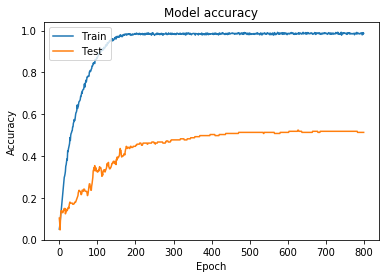

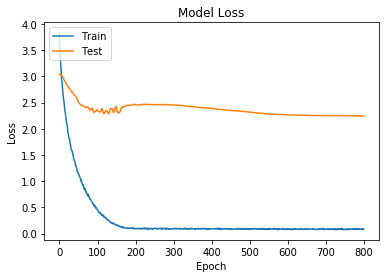

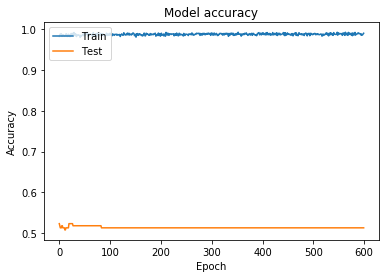

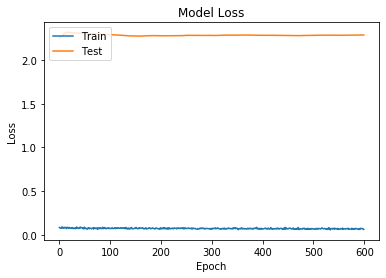

In [43]:
%matplotlib inline
# the first 600 epochs
plot_accuracy(history1)
plot_loss(history1)
# the next 500 epochs
plot_accuracy(history2)
plot_loss(history2)

### Plot confusion matrix

In [44]:
Y_test_pred = DD_Net.predict([X_test_0, X_test_1])

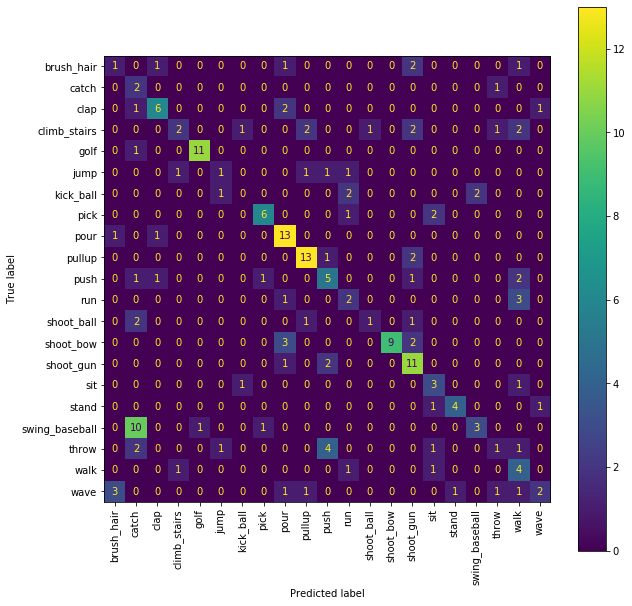

In [45]:
Y_test_pred_cls = np.argmax(Y_test_pred, axis=1)
Y_test_cls = np.argmax(Y_test, axis=1)
Y_test_cls[:10], Y_test_pred_cls[:10]

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
normalize= None # 'true'
cm = confusion_matrix(Y_test_cls, Y_test_pred_cls, normalize=normalize)
# print(cm)
# print(np.sum(np.diagonal(cm)) / np.sum(cm)) # accuracy

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=le.classes_)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(xticks_rotation=90, ax=ax)

### Save/Load Model

In [ ]:
model_path = 'jhmdb_lite_model.h5'
ddnet.save_DDNet(DD_Net, model_path)

In [ ]:
# Load the model back from disk
new_net = ddnet.load_DDNet(model_path)
# Evaluate against test set, you should get the same accuracy
new_net.evaluate([X_test_0,X_test_1],Y_test)

In [ ]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

In [ ]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [ ]:
##########################
## Imputation
##########################

from sklearn.preprocessing import MinMaxScaler
def per_frame_normalized(p):
    # mean and std is calculated within a frame, across all joints
    # separately for x,y
    mean = np.nanmean(p, axis=(1,))
    std = np.nanstd(p, axis=(1,))
    return (p - np.expand_dims(mean, 1)) / np.expand_dims(std, 1)

def per_video_normalize(p):
    # noramlize x and y separate
    mean = np.nanmean(p, axis=(0,1))
    std = np.nanstd(p, axis=(0,1))
    return (p - mean) / std
    
# all_frames_normalized = np.concatenate(list(map(per_frame_normalized, X_interp)))
# print(all_frames_normalized.shape)
# print(all_frames_normalized[0])
# print(count_nan(all_frames_normalized))

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
imp = IterativeImputer(max_iter=10, random_state=0, initial_strategy='mean', verbose=1)
# imp = SimpleImputer(missing_values=np.nan, strategy='mean')
all_frames_normalized_flat_imputed = imp.fit_transform(all_frames_normalized.reshape((all_frames_normalized.shape[0], -1)))
print(all_frames_normalized_flat_imputed[0])

def impute(p, imp):
    # per-frame normalize
    mean = np.nanmean(p, axis=(1,))
    std = np.nanstd(p, axis=(1,))
    p_normalized = (p - np.expand_dims(mean, 1)) / np.expand_dims(std, 1)
    
    # impute
    q = p_normalized.reshape((p_normalized.shape[0], -1))
    q = imp.transform(q)
    q = q.reshape(p.shape)
    print(q.shape)
    # per-frame de-normalize
    return (q *  np.expand_dims(std, 1) ) + np.expand_dims(mean, 1)


# def per_frame_impute(p, imp):
#     q = np.empty_like(p)
#     for i, frame in enumerate(p):
#         scaler = MinMaxScaler()
#         frame_scaled = scaler.fit_transform(frame)
#         f_flat = frame_scaled.reshape((1, -1))
#         f_flat_imputed = imp.transform(f_flat)
#         f_imputed = f_flat_imputed.reshape(frame.shape)
#         frame_imputed = scaler.inverse_transform(f_imputed)
#         q[i] =  frame_imputed
#     return q
print(impute(X_interp[0], imp)[0])

X_imputed = [per_video_normalize(impute(p, imp)) for p in X_interp]
X_test_imputed = [per_video_normalize(impute(p, imp)) for p in X_test_interp]